In [1]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d kmader/food41
! unzip food41.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tacos/11237

 10%|█         | 100/1000 [01:32<12:49,  1.17it/s]

Episode 100/1000, Loss: 0.15835443139076233


 20%|██        | 200/1000 [02:59<11:02,  1.21it/s]

Episode 200/1000, Loss: 0.15081757307052612


 30%|███       | 300/1000 [04:22<10:06,  1.15it/s]

Episode 300/1000, Loss: 0.15992626547813416


 40%|████      | 400/1000 [05:42<07:35,  1.32it/s]

Episode 400/1000, Loss: 0.13416999578475952


 50%|█████     | 500/1000 [06:59<06:03,  1.38it/s]

Episode 500/1000, Loss: 0.1534099578857422


 60%|██████    | 600/1000 [08:17<05:47,  1.15it/s]

Episode 600/1000, Loss: 0.15115441381931305


 70%|███████   | 700/1000 [09:35<03:58,  1.26it/s]

Episode 700/1000, Loss: 0.14531642198562622


 80%|████████  | 800/1000 [10:54<02:28,  1.34it/s]

Episode 800/1000, Loss: 0.12887568771839142


 90%|█████████ | 900/1000 [12:10<01:11,  1.40it/s]

Episode 900/1000, Loss: 0.14619514346122742


100%|██████████| 1000/1000 [13:27<00:00,  1.24it/s]

Episode 1000/1000, Loss: 0.14708617329597473


Test Accuracy: 34.67%
Test Accuracy: 34.96%
Test Accuracy: 33.08%
Test Accuracy: 32.97%
Test Accuracy: 34.28%
Test Accuracy: 32.31%
Test Accuracy: 33.51%
Test Accuracy: 34.75%
Test Accuracy: 34.05%
Test Accuracy: 33.57%


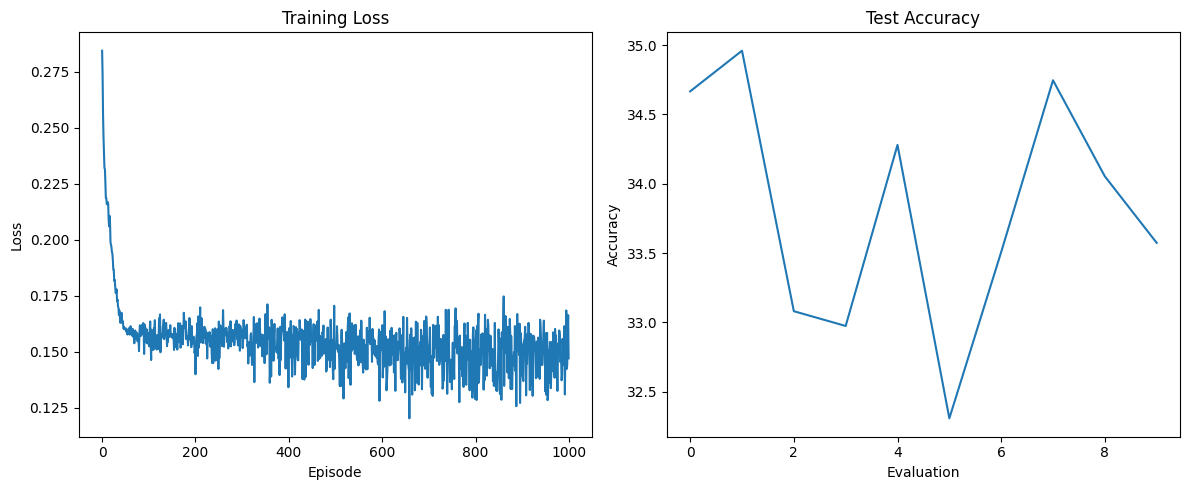

Final Average Test Accuracy: 33.81%


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Feature extractor (simplified for memory efficiency)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(128 * 8 * 8, 512)  # Assuming input images of size 32x32

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x

# Relation Network
class RelationNetwork(nn.Module):
    def __init__(self, feature_dim):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(feature_dim * 2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2, 2))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1 = nn.Linear(64 * 1 * 1, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Meta-Learning Model
class MetaLearningModel(nn.Module):
    def __init__(self, feature_extractor, relation_network):
        super(MetaLearningModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.relation_network = relation_network

    def forward(self, support_set, query_set, n_way, k_shot):
        support_features = self.feature_extractor(support_set)
        query_features = self.feature_extractor(query_set)

        support_features = support_features.view(n_way, k_shot, -1).mean(1)
        n_query = query_features.size(0)

        support_features_ext = support_features.unsqueeze(0).expand(n_query, -1, -1)
        query_features_ext = query_features.unsqueeze(1).expand(-1, n_way, -1)

        pair_features = torch.cat((support_features_ext, query_features_ext), dim=2)
        relations = self.relation_network(pair_features.view(-1, pair_features.size(2), 1, 1))

        return relations.view(-1, n_way)

# Dataset class for Few-Shot Learning
class EnhancedFewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_images = {
            cls: [os.path.join(root_dir, cls, img) for img in os.listdir(os.path.join(root_dir, cls))]
            for cls in self.classes
        }

    def get_episode(self, n_way, k_shot, k_query):
        selected_classes = random.sample(self.classes, n_way)
        support_imgs, query_imgs, support_labels, query_labels = [], [], [], []

        for i, cls in enumerate(selected_classes):
            images = random.sample(self.class_to_images[cls], k_shot + k_query)
            support_imgs.extend(images[:k_shot])
            query_imgs.extend(images[k_shot:])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * k_query)

        support_imgs = torch.stack([self.load_image(img) for img in support_imgs])
        query_imgs = torch.stack([self.load_image(img) for img in query_imgs])
        support_labels = torch.tensor(support_labels)
        query_labels = torch.tensor(query_labels)

        return support_imgs, support_labels, query_imgs, query_labels

    def load_image(self, img_path):
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Training function
def train_meta_model(model, dataset, optimizer, n_way=5, k_shot=5, k_query=15, num_episodes=1000):
    model.train()
    losses = []
    for episode in tqdm(range(num_episodes)):
        support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)

        optimizer.zero_grad()
        relations = model(support_imgs, query_imgs, n_way, k_shot)
        loss = F.mse_loss(relations, F.one_hot(query_labels, num_classes=n_way).float())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Loss: {loss.item()}")

    return losses

# Evaluation function
def evaluate_meta_model(model, dataset, n_way=5, k_shot=5, k_query=15, num_episodes=100):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for episode in range(num_episodes):
            support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)
            relations = model(support_imgs, query_imgs, n_way, k_shot)
            _, predicted = torch.max(relations.data, 1)
            total += query_labels.size(0)
            correct += (predicted == query_labels).sum().item()

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Plotting function
def plot_results(losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.xlabel('Evaluation')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    data_path = '/content/images'  # Update this path
    dataset = EnhancedFewShotDataset(data_path, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))

    feature_extractor = FeatureExtractor()
    relation_network = RelationNetwork(feature_dim=512)  # Assuming the feature dimension is 512
    model = MetaLearningModel(feature_extractor, relation_network)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    losses = train_meta_model(model, dataset, optimizer)

    # Evaluation
    accuracies = []
    for _ in range(10):  # Evaluate 10 times
        accuracy = evaluate_meta_model(model, dataset)
        accuracies.append(accuracy)

    # Plot results
    plot_results(losses, accuracies)

    print(f"Final Average Test Accuracy: {np.mean(accuracies):.2f}%")

    # Save the model
    torch.save(model.state_dict(), 'optimized_meta_learning_model.pth')
